<a href="https://colab.research.google.com/github/Elie87/PythonPojects/blob/main/Audio_Hiring_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Article summary

Most of current music taggers don’t look to the global image of the audio in other words they don’t consider long-term relations when performing audio labeling, and the objective of this paper is to build a model that deal with music as time series sequences, while taking advantage of the large amount of unlabeled audio data that exist, they used the million song dataset (MSD) which only 24% of songs are labeled.<br><br>
In general, the paper has like 2 sections, the first section is building a model that deal with music as long-term time series chunks of data and the second section is the semi-supervised technique, that consists of taking advantage of unlabeled data and data augmentation for a better accuracy.
<br>
Section 1:
The deep learning model they suggest consist of two parts, the first part is CNN used as local feature extractor, which take the Mel spectrogram of the audio as an input and output short-chunk audio features that will be fed to the second part which is a transformer model, because transformers can capture long term relationships in data, and the output will be the class of the given track.
The best model use Adam as an optimizer with learning rate = 0.0001 and the loss used is the binary cross entropy. <br><br>
Section 2:
Most of the audio data is unlabeled and the authors want to be able to utilize the unlabeled data as well as the labeled, so they used a semi-supervised technique which they call “noisy student training”.
In the noisy student training approach we have 2 models the first model is called the teacher and the second model is called the student, which both are models as described in Section 1.
1.	Teacher Training: The First step will be to train the teacher model on labeled data only, using supervised loss
2.	Student Training with supervised loss and semi-supervised loss:
2.1 – Student predict labeled data, store the loss as l1
2.2 – Generate pseudo-labels using the teacher on unlabeled data.
2.3 – Perform data augmentation on unlabeled data.
2.4 – Student predict on augmented unlabeled data and store the loss as l2.
2.5 – Update the Student weights using (l1+l2).

Data augmentation is very important, because it made sure that the student model won’t copy the teacher, and after successful training the student must be able to outperform the teacher. And the same process could be done again iteratively using the student as a teacher and a new student model is trained. Data augmentation techniques used are: “Polarity inversion, additive noise, random gain, filters, delay, pitch shift”.<br>
They achieved state of the art result, in music tagging and their model has a more stable results when longer audio chunks are used as inputs. 


# Part 2 - Feautre extraction from Raw audio

In [ ]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# import librarie
import pandas as pd 
import numpy as np 

import librosa 
import librosa.feature
import os
import glob

In [ ]:
audio_path = '/content/drive/My Drive/Data/Groover_challenge/part_2_raw_audio'
audio_data=[]
for filename in glob.glob(os.path.join(audio_path, '*.wav')):
    x, sr = librosa.load(filename)
    audio_data.append(x)



In [ ]:
#understand the data
print(len(audio_data))
print(audio_data[0][-1])
print(len(audio_data[1]))
print(len(audio_data[19]))

20
-0.39138794
661794
661504



First we will extract features for traditional ML and AI classification techniques, then we will extract spectrogram that can be used with deep learning models such as CNN.




##1- Features used with traditonal ML classification models.

All this features are extensively used for audio and music classification, for the following reasons



###A - Time domain features

### A-1. Zero crossing ( sum, mean, var)
 zero crossing rate is the number of times a signal crosses the horizontal x-axis, in other word change his sign value.
importance: Extremely to audio segmentation, and to find voice signal and none voiced signals

###A-2. root mean square energy (sum, mean, var)
this is also a time domain feature, we get this value by taking the root mean sqaure energy for all the samples in a given frame.
importance: Indicator of loudness, less sensitive to outliers because calculated on all the samples.



###B - Frequency domain feature

###B-1. spectral rolloff ( mean, variance)
Spectral rolloff is the frequency below which (for example: 85%)  of the total spectral energy lies. It mainly used to differentiate between speaking, loading and singing. 

###B-2. spectral bandwidth ( mean, variance)
It is the weighted mean of the distances of frequency bands from the spectral centroid.
It mainly describes how the energy is spead across the frequency bands. if the energy is more spread across the frequency bands  the bandwidth value will increase
###B-3. Spectral centroid ( mean, variance)
this a frequency domain feature, this feature will reveal the frequency band in which we have the most of the energy.
###B-4. harmony (mean, var)
Could be describe as the sound of notes heard simultaneously, or one after the other




###C - Time-frequency features

###C-1. mfcc mel frequency Cepstral coefficient ( mean, var for each coefficient)
MFCCs are cepstral coefficients which correspond to a sinusoidal transformation of the power of a signal, in other words:
mel-frequency it a scale for pitch, it is related to mel-spectrogram( explained later in the notebook), and each coefficient will describe a certain characteristic in the sound.

In [ ]:
#understand shape of features.
raw_audio=audio_data[0]
print(librosa.zero_crossings(y=raw_audio).shape, librosa.feature.rms(y=raw_audio).shape, librosa.feature.spectral_rolloff(y=raw_audio,sr=sr).shape, librosa.feature.spectral_bandwidth(y=raw_audio,sr=sr).shape)
print(librosa.feature.spectral_centroid(y=raw_audio,sr=sr).shape, librosa.effects.harmonic(y=raw_audio).shape, librosa.feature.mfcc(y=raw_audio,sr=sr).shape, librosa.feature.mfcc(y=raw_audio,sr=sr)[0].shape)


(661794,) (1, 1293) (1, 1293) (1, 1293)
(1, 1293) (20, 1293) (1293,)
(661794,)


We will first extract the features for all the samples taken from each audio file, using the librosa libeary then we will aggregrate the result using numpy library for getting the sum, mean, variacne to get a description from the hole time of the audio .

In [ ]:
def feature(raw_audio):
  feat_list=[]
  #1-zero crossing
  zcr=librosa.zero_crossings(y=raw_audio)
  feat_list.append(sum(zcr))
  feat_list.append(np.mean(zcr))
  feat_list.append(np.var(zcr))

  #2-root_mean_squared_energy
  rmse = librosa.feature.rms(y=raw_audio)[0]
  feat_list.append(sum(rmse))
  feat_list.append(np.mean(rmse))
  feat_list.append(np.var(rmse))

  #3- spectral rollof
  rolloff = librosa.feature.spectral_rolloff(y=raw_audio,sr=sr)[0]
  feat_list.append(np.mean(rolloff))
  feat_list.append(np.var(rolloff))

  #4- spectral bandwidth
  bandwidth = librosa.feature.spectral_bandwidth(y=raw_audio,sr=sr)[0]
  feat_list.append(np.mean(bandwidth))
  feat_list.append(np.var(bandwidth))

  #5- spectral centroid
  centroid = librosa.feature.spectral_centroid(y=raw_audio,sr=sr)[0]
  feat_list.append(np.mean(centroid))
  feat_list.append(np.var(centroid))

  #6- harmony
  harmony = librosa.effects.harmonic(y=raw_audio)
  feat_list.append(np.mean(harmony))
  feat_list.append(np.var(harmony))

  #7- mfcc audio
  mfcc = librosa.feature.mfcc(y=raw_audio,sr=sr)
  for i in mfcc:
    feat_list.append(np.mean(i))
    feat_list.append(np.var(i))



  return feat_list



In [ ]:
col = ['zcr_sum','zcr_mean','zcr_var','rmse_sum','rmse_mean','rmse_var','rolloff_mean','rolloff_var','bandwidth_mean','bandwidth_var',
           'centroid_mean','centroid_var','harmony_mean','harmony_var','mfcc1_mean','mfcc1_var', 'mfcc2_mean','mfcc2_var','mfcc3_mean', 'mfcc3_var','mfcc4_mean','mfcc4_var',
           'mfcc5_mean','mfcc5_var', 'mfcc6_mean','mfcc6_var', 'mfcc7_mean','mfcc7_var', 'mfcc8_mean','mfcc8_var','mfcc9_mean', 'mfcc9_var',
           'mfcc10_mean','mfcc10_var', 'mfcc11_meam','mfcc11_var', 'mfcc12_mean','mfcc12_var', 'mfcc13_mean','mfcc13_var','mfcc14_mean', 'mfcc14_var',
           'mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var', 'mfcc17_mean','mfcc17_var', 'mfcc18_mean','mfcc18_var','mfcc19_mean', 'mfcc19_var', 'mfcc20_mean','mfcc20_var']
df = pd.DataFrame(columns=col)
i=0

#append each created feature_listt as new row to the dataframe
for audio in audio_data:
  df.loc[i,:]=feature(audio)
  i+=1
print(df.shape)
df.head()

,zcr_sum,zcr_mean,zcr_var,rmse_sum,rmse_mean,rmse_var,rolloff_mean,rolloff_var,bandwidth_mean,bandwidth_var,centroid_mean,centroid_var,harmony_mean,harmony_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_meam,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,34438,0.0520373,0.0493295,99.7035,0.0771102,0.00594571,2477.28,994270,1573.5,84832.4,1198.46,161880,-3.19686e-05,0.00841344,-284.848,6201.42,108.75,676.823,9.12968,1447.73,51.2513,294.615,18.1237,210.465,7.63278,181.739,8.77537,121.513,2.36538,103.189,0.019261,93.4117,2.23693,106.556,4.19063,84.3826,-3.30458,97.5618,1.61405,68.6595,2.69186,74.7123,3.37613,93.7264,3.29279,116.547,-4.52448,138.137,0.496721,105.847,5.92198,140.871,3.21454,170.079
1,61300,0.092627,0.0840472,176.263,0.136321,0.000473977,5198.59,569657,2375.25,53001.8,2278.96,170896,-0.0021679,0.0102759,-109.513,826.221,86.9214,227.904,-8.59419,279.784,64.4895,82.2824,-6.30151,55.0854,43.6435,38.8613,-8.29083,51.5938,28.5458,54.8324,-14.0827,77.6088,8.12863,85.4479,-21.4881,69.4597,11.0883,95.005,-5.09169,91.581,3.9765,68.7978,-12.8612,52.8363,12.3368,61.2788,0.0205169,73.3341,-0.743094,56.244,-5.13096,95.9652,3.29794,92.5694
2,73923,0.111701,0.0992238,314.495,0.243229,0.00508612,4658.38,1.09064e+06,2191.66,75477.9,2207.22,184258,2.31948e-05,0.0259861,-28.9512,1958.66,104.518,307.118,-30.9715,307.66,38.1585,109.134,-8.0016,133.474,30.8861,96.5461,-20.6042,98.6484,25.8161,69.8342,-12.9627,84.6478,16.9378,53.4286,-12.2704,58.6158,10.7824,37.4188,-10.5573,46.1764,6.87726,40.2294,-10.2937,40.6005,6.95757,46.9384,-10.2596,51.7355,0.704702,46.4594,-5.99973,31.9267,1.35079,44.7373
3,61802,0.0933856,0.0846647,89.4075,0.0691473,0.00128384,2840.96,438169,1651.17,69178.8,1551.2,123270,-0.000649561,0.00420184,-197.192,5622.18,137.404,607.725,-34.156,417.594,25.3627,86.014,-5.27717,46.0605,-2.77517,43.0649,-9.49825,36.5269,-7.60898,39.6362,-7.65277,48.3171,-5.66613,42.2792,-4.37994,52.3242,-5.42462,50.7936,-3.53487,48.089,-5.65874,34.7213,-1.88998,37.3924,-2.88021,34.1082,-3.48316,34.7514,-4.02983,48.3502,-7.29797,57.2783,-4.18819,108.393
4,23887,0.0360943,0.0347915,26.0491,0.0201463,0.000181157,749.141,14686.1,1358.4,77909.3,690.201,7911.25,-0.00156788,0.000534797,-465.922,1487.96,180.202,434.315,56.6828,323.608,11.0313,137.391,5.83522,48.878,0.734212,48.2929,-3.96238,43.8651,-5.88542,43.3263,-8.46198,42.8857,-9.78401,41.5595,-7.6926,49.6099,-3.25473,45.1666,-1.85745,50.9763,-4.00684,62.9923,-4.10101,74.2933,-2.46819,83.5507,-2.3574,65.3103,-2.99399,56.0418,-3.22603,59.7541,-1.71507,36.4059


##2- Feature used with Deep learning models
### the spectrogram technique for Complex deep learning such as CNN.

this feature extraction technique is used recently with CNN, RNN and transformers where time is an essential component t as well locking to the global and local image to the signal and been able to classify it without the need to complex feature extraction.

Spectrogram, is a time-frequency representation of the signal, where time is represented on the x axis and frequencies on the y axis, which allow to see different frequency components at different pint of time, as well the amount of contribution that each frequency band have for s specific time, could be describe with colors as 3rd dimension to the representation (graph, plot ..)
this creates spectrogram (e.g matrix,image, ) for CNN model.

A Mel-spectrogram example:

![](https://drive.google.com/uc?export=view&id=1R3aHIBZVRPOLXXG7_hW71pqd5X5M86fS)


In [ ]:
for audio in audio_data:
  spect = librosa.feature.melspectrogram(y=audio, sr=sr)
  spect = librosa.power_to_db(spect, ref=np.max)
  #print(spect.shape)

<br>

<br>

#Part 3 - Classsifications

In [ ]:
#import usefull librarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


Path_to_data = '/content/drive/My Drive/Data/Groover_challenge/part3_GrooverChallengeDataset.csv'


##1- Data importing

In [ ]:
#import data
data = pd.read_csv(Path_to_data)  # read dataset from disk
data.head()  # print first 5 rows


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


##2- Data Understanding
With statistics and summarize

In [ ]:
#understand shape and type of data
print(data.shape)
print(data.info())

(1000, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   length                   1000 non-null   int64  
 1   chroma_stft_mean         1000 non-null   float64
 2   chroma_stft_var          1000 non-null   float64
 3   rms_mean                 1000 non-null   float64
 4   rms_var                  1000 non-null   float64
 5   spectral_centroid_mean   1000 non-null   float64
 6   spectral_centroid_var    1000 non-null   float64
 7   spectral_bandwidth_mean  1000 non-null   float64
 8   spectral_bandwidth_var   1000 non-null   float64
 9   rolloff_mean             1000 non-null   float64
 10  rolloff_var              1000 non-null   float64
 11  zero_crossing_rate_mean  1000 non-null   float64
 12  zero_crossing_rate_var   1000 non-null   float64
 13  harmony_mean             1000 non-null   float64
 14  harmony_var   

We notice that the data has 1000 row and 59 field including the output,
All our inputs are of type float64 and only the output is of type object,
which means that in the data preprocessing we won't have to do one encoding or  label encoding for the inputs becasue they are all of type float.<br>
But we will have to do Standariztion beofre giving it to the model.

In [ ]:
data.drop(columns=['length'], inplace=True) # Length of the audio is not an important feature for classification

In [ ]:
data.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,0.103612,0.002986,-3.659332e-04,0.012540,-0.000395,5.670073e-03,119.505363,-144.472987,3747.875414,99.554278,706.899539,-8.920291,468.286436,36.292447,220.447219,-1.144840,174.404462,14.633491,127.232071,-5.129038,116.367019,10.119172,88.198988,-6.994062,88.566933,7.729785,81.733490,-6.021069,75.551228,4.471693,68.670817,-4.795884,67.871712,1.781900,64.764096,-3.869308,62.873761,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,0.041821,0.003024,1.683946e-03,0.011653,0.001082,6.500325e-03,28.264176,100.229406,2770.558394,31.330873,439.120256,21.690676,287.143462,16.664665,116.236941,12.221340,100.767823,11.839591,68.475115,9.940460,58.400048,10.463270,41.048213,8.283921,39.494072,7.937309,36.733649,6.817013,38.135183,6.715787,32.625534,6.170181,33.154276,5.008385,34.450290,4.873599,33.904101,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,0.021697,0.000044,-2.606458e-02,0.000049,-0.007150,8.299008e-07,54.978391,-552.120056,174.571365,-1.461542,93.104752,-89.870193,35.467754,-18.727547,34.263149,-38.890347,29.912008,-28.415911,20.847921,-32.930431,29.027332,-24.915823,22.464230,-31.640574,25.825863,-12.050177,19.273201,-28.057501,21.402756,-15.796446,18.642517,-27.523129,17.293922,-12.594489,14.250607,-17.539125,9.769691,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,0.070244,0.001079,-1.041584e-04,0.004383,-0.000537,1.292592e-03,99.384014,-200.763893,1844.488129,76.779915,398.020767,-24.219811,270.466576,24.108212,129.397377,-9.979157,101.266209,5.098573,76.505194,-12.870810,73.546917,1.609181,57.349041,-13.246939,59.882313,1.620753,55.734016,-10.964135,51.242420,-0.547371,46.854038,-9.357906,46.294396,-1.639417,43.416593,-7.165884,42.236251,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,0.099503,0.002022,-3.176783e-06,0.008768,-0.000036,3.410864e-03,117.453835,-120.286385,3135.16369

Make sure that no feild of the data has low number of unique vlaue,<br>
becasue if numbre of unique values < 10 it is better to treat the data as categorical

In [ ]:
data.nunique()

chroma_stft_mean           986
chroma_stft_var            986
rms_mean                   986
rms_var                    986
spectral_centroid_mean     986
spectral_centroid_var      986
spectral_bandwidth_mean    986
spectral_bandwidth_var     986
rolloff_mean               986
rolloff_var                986
zero_crossing_rate_mean    984
zero_crossing_rate_var     986
harmony_mean               986
harmony_var                986
perceptr_mean              986
perceptr_var               986
tempo                       35
mfcc1_mean                 986
mfcc1_var                  986
mfcc2_mean                 986
mfcc2_var                  986
mfcc3_mean                 986
mfcc3_var                  986
mfcc4_mean                 986
mfcc4_var                  986
mfcc5_mean                 986
mfcc5_var                  986
mfcc6_mean                 986
mfcc6_var                  986
mfcc7_mean                 986
mfcc7_var                  986
mfcc8_mean                 986
mfcc8_va

Confirme that output data is well balanced, and can be used later to train the model.


In [ ]:
#this line confirmed that our data is well balanced, and can be used later to train the model
data['label'].value_counts()

country      100
classical    100
jazz         100
blues        100
metal        100
pop          100
disco        100
reggae       100
hiphop       100
rock         100
Name: label, dtype: int64

##3- Data preprocessing

In [ ]:
#split data to input and outputs
X=data.iloc[:,0:-1]
Y=data.iloc[:,-1]

In [ ]:
print(X.columns)
print(type(X))
X.head()


Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'],
      dtype='object')
<

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [ ]:
print(type(Y))
Y.head()

<class 'pandas.core.series.Series'>


0    blues
1    blues
2    blues
3    blues
4    blues
Name: label, dtype: object

Using the correlation plot as exploratory data analysis step,<br>
to detrmine if data is muliptle inputs is highly correlated only one should be left becasue it is capalbe of representing the other.

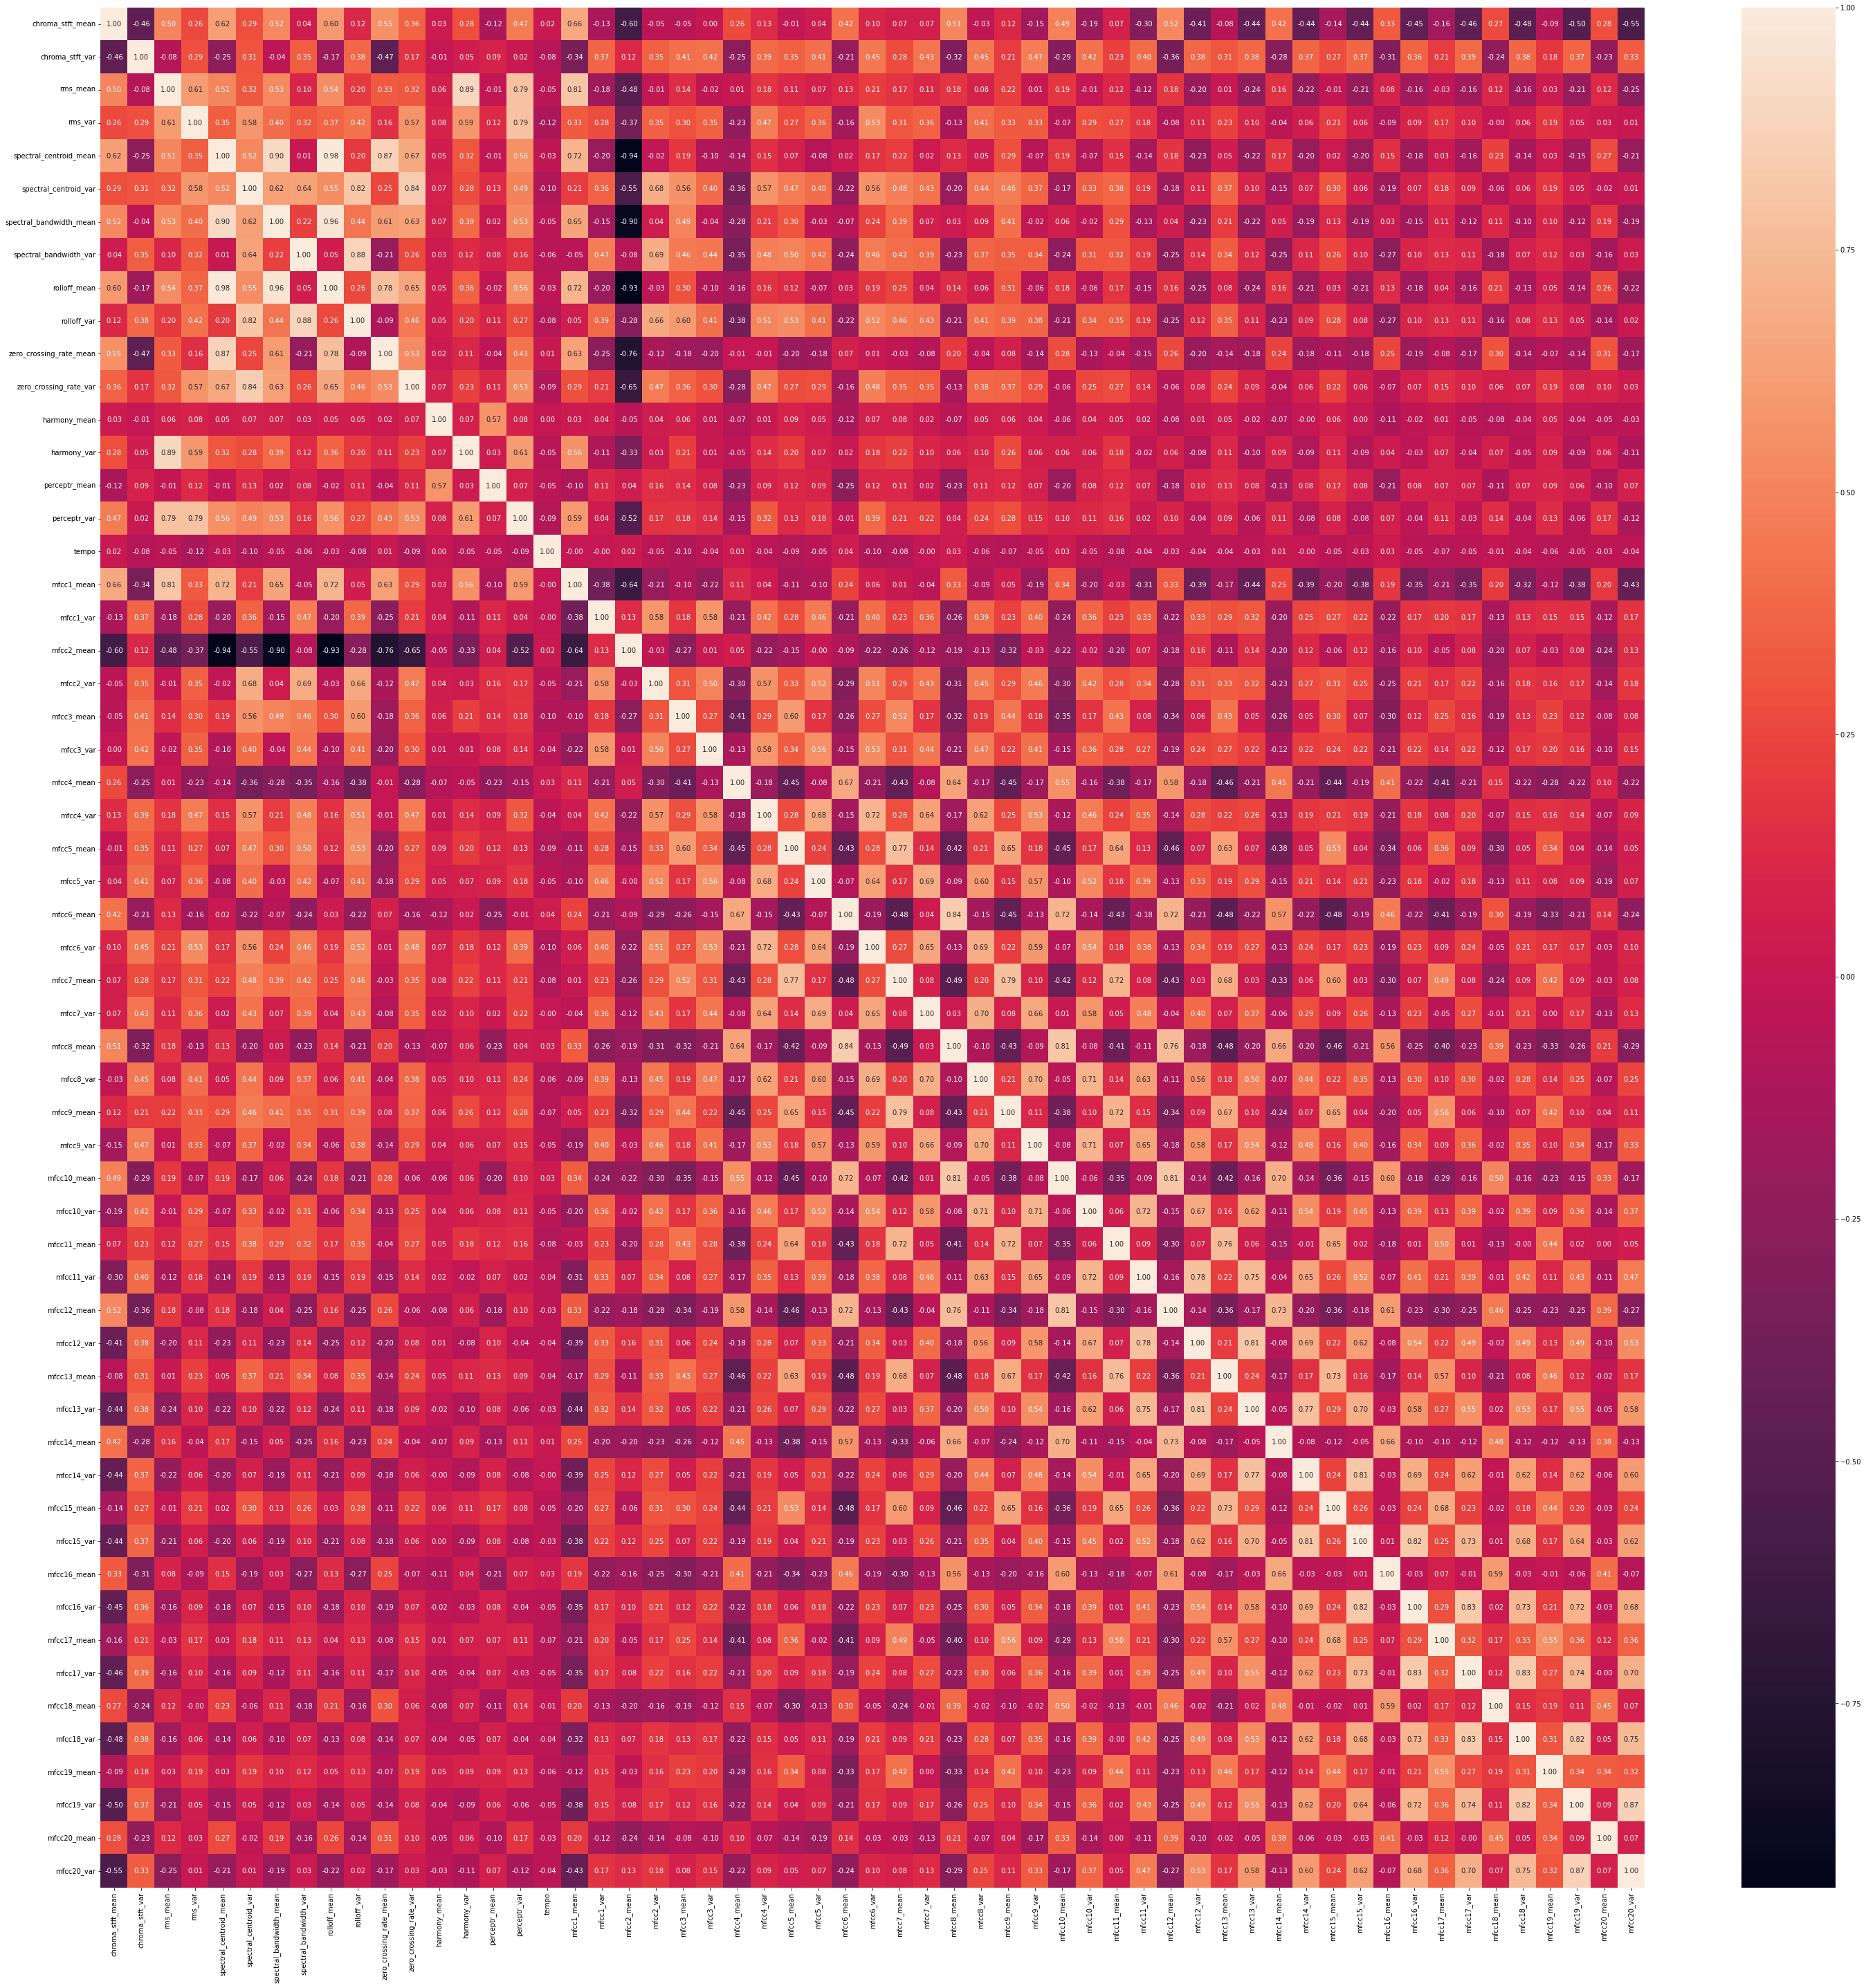

In [ ]:
#Corelation plot to between the input if multiple is highly correlated 
fig,ax = plt.subplots(figsize=(50, 50))
sns.heatmap(X.corr(), annot=True, fmt='.2f', ax=ax) 
plt.show()

In [ ]:
cor=X.corr().abs()
#select the upper triangle of the matrix becaue it is a mirror
cor_uper=cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))
# print(cor_uper)

#get the fields with high coreelation
to_drop=[col for col in cor_uper.columns if any(cor_uper[col]>0.91) ]
print(to_drop) 
#I can drop the following fileds because they are already represented by others, due to high correaltion between them

['rolloff_mean', 'mfcc2_mean']


The correaltion heat map above confirms that the feature spectral_centroid_mean is coreelated to mfcc2_mean which is correlated to rolloff_mean.<br>
which means that all these features could be represented by spectral_centroid_mean.

In [ ]:
#drop the high corelated fields
X.drop(columns=to_drop, inplace=True)
print(X.shape)


(1000, 55)


Next we will convert the ouptput to dummy "numerical"
to be able to perform the predcitions

---





In [ ]:
#Convert output classes to dummy variables
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(Y)
print(encoded_y.shape)
name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(name_mapping)

#No need to convert to one hot encoding, keras classifier will take care of that part
#from keras.utils import np_utils
#dummy_y = np_utils.to_categorical(encoded_y) 
#print(dummy_y)



(1000,)
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [ ]:
#split into train and test split
from sklearn.model_selection import train_test_split

x= X.values  

x_train, x_test, y_train, y_test = train_test_split(x, encoded_y, test_size=0.20, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(800, 55) (800,)
(200, 55) (200,)


We must perform Standariztion for the inputs for better results, we will use the Standarscalar technique to perserve the outliers.

In [ ]:
from sklearn.preprocessing import StandardScaler # Standardizing numerical features
scaler = StandardScaler()
x_train_stand = scaler.fit_transform(x_train)  # we fit the scalar only on the training data,
                                               #because we concider the test data has never been available
x_test_stand = scaler.transform(x_test)


In [ ]:
print('shape of input data for taining is ',x_train_stand.shape)
print('shape of output data for taining is ', y_train.shape)
print('shape of input data for testing is ', x_test_stand.shape)
print('shape of output data for testing is ', y_test.shape)


shape of input data for taining is  (800, 55)
shape of output data for taining is  (800,)
shape of input data for testing is  (200, 55)
shape of output data for testing is  (200,)


##4- Testing of Tadiotanl AI models


1. Decison Tree
2. Random Forest
3. Support Vectore machine

In [ ]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

CLF_1= DecisionTreeClassifier(max_depth = None).fit(x_train_stand, y_train)
CLF_2 = RandomForestClassifier(max_depth=2, random_state=0)
CLF_3=SVC(gamma='auto')

models =[]
models.append(('DT',CLF_1))
models.append(('RF',CLF_2))
models.append(('SVM',CLF_3))

scores=[]
names=[]

for name,model in models:
  model.fit(X=x_train_stand, y=y_train)
  predicted_out=model.predict(X=x_test_stand)
  score=accuracy_score(y_test,predicted_out)

  scores.append(score)
  names.append(name)
  output="%s: %f" % (name,score) # this line need research 
  print(output)

# dtree_predictions = dtree_model.predict(x_test)
 
# score = accuracy_score(y_test, dtree_predictions)
print(score)

DT: 0.455000
RF: 0.380000
SVM: 0.695000
0.695


The Result of the Support vector machine is considered good for multi-class classification, especially for a triagonal model, mainly because of the good data and feature extraction and pre-processing techniques. <br>



And the best method to understand the result of our classification model is to compute the confusion matrix, tis matrix will clarify which class the model was able to predict correctly and if the model predicts wrong, we will know which wrong class was predicted for a specific class.

 the SVM score is 69.5%


Text(91.68, 0.5, 'predicted label')

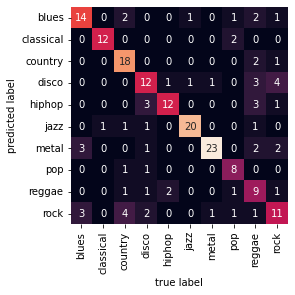

In [ ]:
  SVM = SVC(gamma='auto')
  SVM.fit(X=x_train_stand, y=y_train)
  SVM_predicted_out=SVM.predict(X=x_test_stand)
  score=accuracy_score(y_test,predicted_out)
  print(" the SVM score is "+str(score*100)+"%")

matrix = confusion_matrix(y_test, SVM_predicted_out)

labels=encoder.classes_ 

sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

##5- Testing of ANN models

###4.2 -Kfold cross validation

ANN model creation<br>

we will use the KFold technique to get well understanding on the model performance using all the training data.<br>
The Kfold will insure all the data data is going to be used as test. <br>
Different model architecture will be tested to find the best architecture. 


because it is a multi-class classification:

*   The metric accuracy is going to be used
*   The loss function is going to be categorical cross entropy
*   The last layer will have the softmax as activation

*   We have 55 input so the input dim is 55
*   The number output classes is 10 so the last layer will have 10 neurones.





In the below cell several architecture were used with the CV k-fold testing to compare different model architecture before we chose a convenient one

In [ ]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# define baseline model
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(30, input_dim=(55),use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(10, activation='softmax')) #we have 10 output
  
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(estimator, x_train_stand, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Accuracy: 68.88% (3.33%)


###4.3- Grid Search

After finding a good ANN architecture model (by using Kfold cross validation) we use the grid search to find the best parameters of the model by varying these parameters such as the optimizer, learning rate, momentum the number of epochs and batches size.<br>

In the below code more parameters could be added to the grid search but it was taking to much time

In [ ]:
from sklearn.model_selection import GridSearchCV
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

def model(learn_rate, optimizer, momentum): #these values must be given to able to perform grid search on them
	# create model
  model = Sequential()
  model.add(Dense(30, input_dim=(55),use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
  return model


# create model
model = KerasClassifier(build_fn=model, epochs=10, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2]
momentum = [0.0, 0.2]
optimizers=['adam','sgd']
batchs=[5,10,20]
epochs=[5,50] # this is just an example i wont use more than 50 epochs in grid search, because it is taking to mach time

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batchs, learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3) #cv: number of cross-validation you have to try for each selected set of hyperparameters. 
grid_result = grid.fit(x_train_stand, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----------")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Best: 0.656280 using {'batch_size': 5, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'adam'}
-----------


After finding the best psooible model and the best architecture to be used with this model using grid search we build and train and test this model.

In [ ]:
print('shape of input data for taining is ',x_train_stand.shape)
print('shape of output data for taining is ', y_train.shape)
print('shape of input data for testing is ', x_test_stand.shape)
print('shape of output data for testing is ', y_test.shape)


shape of input data for taining is  (800, 55)
shape of output data for taining is  (800,)
shape of input data for testing is  (200, 55)
shape of output data for testing is  (200,)


###4.4- Train and save final model

In the below cell we will build the model using the best architecture found from kfold cross validation, and the best model parameters found using grid search: {'batch_size': 5, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'adam'}<br>

We will use early stopping with patient of 100 epoch to stop the model from training in case the accuracy on the validation didn't increase for more than 100 epochs. <br>

We will use also checkpoint to save the model weights, each time a better accuracy on the testing data is achieved.

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

def create_model():
  model = Sequential()
  model.add(Dense(30, input_dim=(55),use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc']) #From the TensorFlow source code, the sparse_categorical_crossentropy is defined as categorical crossentropy with integer targets:
  return model

# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=0,patience=100)

checkpoint_filepath = '/content/drive/My Drive/Data/Groover_challenge/weights_best.hdf5'


checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') #Naming convention: monitor='val_accuracy' won't work

# fit model
kerasClass=KerasClassifier(build_fn=create_model)
kerasClass.fit(x_train_stand, y_train, validation_data=(x_test_stand, y_test),epochs=1000, batch_size=5, verbose=1,callbacks=[es,checkpoint])
ANN_predict=kerasClass.predict(x_test_stand)
print(ANN_predict)
print(y_test)
score = accuracy_score(y_test, ANN_predict)
print(score)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Epoch 1/1000
159/160 [============================>.] - ETA: 0s - loss: 2.0716 - acc: 0.2503
Epoch 00001: val_acc improved from -inf to 0.35000, saving model to /content/drive/My Drive/Data/Groover_challenge/weights_best.hdf5
160/160 [==============================] - 2s 7ms/step - loss: 2.0708 - acc: 0.2500 - val_loss: 1.9091 - val_acc: 0.3500
Epoch 2/1000
146/160 [==========================>...] - ETA: 0s - loss: 1.5360 - acc: 0.4507
Epoch 00002: val_acc improved from 0.35000 to 0.45500, saving model to /content/drive/My Drive/Data/Groover_challenge/weights_best.hdf5
160/160 [==============================] - 1s 4ms/step - loss: 1.5275 - acc: 0.4475 - val_loss: 1.4957 - val_acc: 0.4550
Epoch 3/1000
148/160 [==========================>...] - ETA: 0s - loss: 1.2041 - acc: 0.5622
Epoch 00003: val_acc improved from 0.45500 to 0.49000, saving model to /content/drive/My Drive/Data/Groover_challenge/weights_best.hdf5
160/160 [==============================] - 1s 5ms/step - loss: 1.1957 - ac

The model was able to reach the best accuracy score on the valdiation data for 72.0%  on the epoch 68, the weigths at this epochs were saved and will be used for later testing, and the later epoch will be neglected beacause they are most likely overfitted on the training data. 

###4.5 - Load the best model

In [ ]:
def create_model(weights_path='/content/drive/My Drive/Data/Groover_challenge/weights_best.hdf5'):
  model = Sequential()
  model.add(Dense(30, input_dim=(55),use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(20,use_bias = True, activation='relu'))
  model.add(Dense(10, activation='softmax')) 

  optimizer = Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc']) #From the TensorFlow source code, the sparse_categorical_crossentropy is defined as categorical crossentropy with integer targets
  model.load_weights(weights_path)
  return model
model=create_model()
ANN_predict_proba=model.predict(x_test_stand)
ANN_predict_label=ANN_predict_proba.argmax(-1)  # this is used to convort propabilities to numerical labels so we can compute the score

score = accuracy_score(y_test, ANN_predict_label)
print("the score on the testing set from the best trained moodel is ",score)


the score on the testing set from the best trained moodel is  0.72


##6- Test the result using confusion matrix

The best method to understand the result of our classification model is to compute the confusion matrix, tis matrix will clarify which class the model was able to predict correctly and if the model predicts wrong, we will know which wrong class was predicted for a specific class.

the score is 72.0%
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Text(91.68, 0.5, 'predicted label')

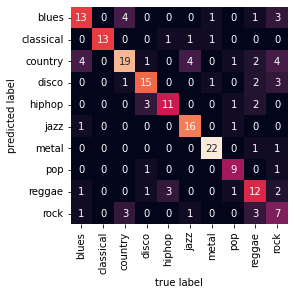

In [ ]:
import sys
from sklearn.metrics import accuracy_score, confusion_matrix

np.set_printoptions(threshold=sys.maxsize)
ANN_predict=kerasClass.predict(x_test_stand)

score = accuracy_score(y_test,ANN_predict_label)
print("the score is "+str(score*100)+"%")

# print(encoder.inverse_transform(ANN_predict_label)) #convert from label to class name for visualisation

matrix = confusion_matrix(y_test, ANN_predict)
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

labels=encoder.classes_ 

sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')